1
The Associ
{'source': 'singapore_infocomm.txt'}


<function matplotlib.pyplot.show(close=None, block=None)>

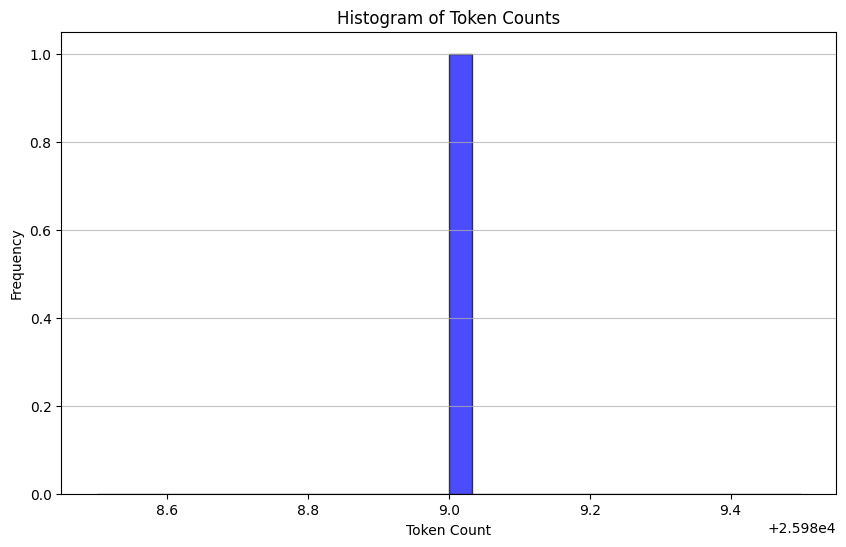

In [4]:
import matplotlib.pyplot as plt
import tiktoken
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# Singapore docs
from langchain.document_loaders import TextLoader
loader = TextLoader("singapore_infocomm.txt")

#Load the document by calling loader.load()
docs = loader.load()

print(len(docs))
print(docs[0].page_content[0:10])

print(docs[0].metadata)




docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [5]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 25989


In [6]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)

In [8]:
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings()

from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

# from langchain_anthropic import ChatAnthropic

# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

In [9]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap.umap_ as umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a list of occupations and their related skills and knowledge.
    
    The list includes occupations from different sectors and subsectors.
    
    Give a detailed summary of the list provided.
    
    Jobs:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

/Users/bruxo/miniconda3/envs/nlp380/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--


In [11]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [12]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
# rag_chain.invoke("List all the skills, knowledge and abilities required by a Embedded Systems Engineering Manager.")

"""
The Embedded Systems Engineering Manager plans and oversees the embedded system design, development and integration aligned with policy and standards. He/She scopes out requirement specifications, plans project life cycles and estimates resources and budgets. He communicates with stakeholders to gain buy-in and coordinates deliverables with multiple product line owners. He oversees the preparation of test procedures and performance of qualification testing as well as development of product and design documentation. He guides validation and verification of overall system design concepts and framework. He provides manufacturing and final product release support. He manages and develops junior staff. He leads a team and is responsible for managing projects and resources of the team, as well as coaching team members to build their technical capabilities. He is also an expert in microprocessor and microcontroller-based hardware components, and the interconnectivity between systems and networks. The Embedded Systems Engineering Manager manages a team of engineers and other stakeholders, he is a confident leader who can justify his decisions, put forth his ideas in a persuasive manner and engage others to gain buy-in. He should also be analytical and structured in the planning and management of embedded system design and integration projects, anticipating problems and developing solutions to them.
"""

'\nThe Embedded Systems Engineering Manager plans and oversees the embedded system design, development and integration aligned with policy and standards. He/She scopes out requirement specifications, plans project life cycles and estimates resources and budgets. He communicates with stakeholders to gain buy-in and coordinates deliverables with multiple product line owners. He oversees the preparation of test procedures and performance of qualification testing as well as development of product and design documentation. He guides validation and verification of overall system design concepts and framework. He provides manufacturing and final product release support. He manages and develops junior staff. He leads a team and is responsible for managing projects and resources of the team, as well as coaching team members to build their technical capabilities. He is also an expert in microprocessor and microcontroller-based hardware components, and the interconnectivity between systems and ne

'\nThe Embedded Systems Engineering Manager plans and oversees the embedded system design, development and integration aligned with policy and standards. He/She scopes out requirement specifications, plans project life cycles and estimates resources and budgets. He communicates with stakeholders to gain buy-in and coordinates deliverables with multiple product line owners. He oversees the preparation of test procedures and performance of qualification testing as well as development of product and design documentation. He guides validation and verification of overall system design concepts and framework. He provides manufacturing and final product release support. He manages and develops junior staff. He leads a team and is responsible for managing projects and resources of the team, as well as coaching team members to build their technical capabilities. He is also an expert in microprocessor and microcontroller-based hardware components, and the interconnectivity between systems and networks. The Embedded Systems Engineering Manager manages a team of engineers and other stakeholders, he is a confident leader who can justify his decisions, put forth his ideas in a persuasive manner and engage others to gain buy-in. He should also be analytical and structured in the planning and management of embedded system design and integration projects, anticipating problems and developing solutions to them.\n'

In [26]:
rag_chain.invoke("List all the skills, knowledge and abilities required by a Embedded Systems Engineering Manager. List them as a list categorized in Skills, Knowledge and Abilities.")


Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


'Based on the information provided, the key skills, knowledge and abilities required by an Embedded Systems Engineering Manager can be categorized as follows:\n\nSkills:\n- Project management and planning\n- Team leadership and development\n- Communication and stakeholder management\n- Problem-solving and decision-making\n\nKnowledge:\n- Embedded system design, development and integration\n- Microprocessor and microcontroller-based hardware components\n- Interconnectivity between systems and networks\n- Programming languages required by the organization\n- Policy and standards related to embedded systems\n\nAbilities:\n- Justify decisions and persuade others\n- Engage and gain buy-in from stakeholders\n- Analytical and structured thinking for planning and managing projects\n- Anticipate problems and develop solutions'

'Based on the information provided, the key skills, knowledge and abilities required by an Embedded Systems Engineering Manager can be categorized as follows:\n\nSkills:\n- Project management and planning\n- Team leadership and development\n- Communication and stakeholder management\n- Problem-solving and decision-making\n\nKnowledge:\n- Embedded system design, development and integration\n- Microprocessor and microcontroller-based hardware components\n- Interconnectivity between systems and networks\n- Programming languages required by the organization\n- Policy and standards related to embedded systems\n\nAbilities:\n- Justify decisions and persuade others\n- Engage and gain buy-in from stakeholders\n- Analytical and structured thinking for planning and managing projects\n- Anticipate problems and develop solutions'

In [14]:
jsonres = rag_chain.invoke("List all the skills, knowledge and abilities required by a Embedded Systems Engineering Manager. Print it in JSON format with groups of Skills, Knowledge and Abilities.")


Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


In [15]:
jsonres

'```json\n{\n  "Skills": [\n    "Security systems monitoring",\n    "Cybersecurity standards familiarity",\n    "Incident analysis and resolution",\n    "Security advisories preparation",\n    "On-call availability",\n    "Cybersecurity tools and techniques proficiency",\n    "Clear communication",\n    "Effective coordination",\n    "Security strategy development",\n    "Corporate information protection",\n    "IT security architecture design",\n    "Cyber Risk Maturity Model improvement",\n    "Regulatory compliance advising",\n    "Leadership and decisiveness",\n    "Cyber risk assessment",\n    "Risk mitigation management",\n    "Cybersecurity policy implementation",\n    "Analytical and systematic risk identification",\n    "Team player with strong communication",\n    "Forensics investigation strategy development",\n    "Threat data analysis",\n    "Security incident solutions development",\n    "Incident response strategy development",\n    "Cyber-incident report presentation",\

'```json\n{\n  "Skills": [\n    "Security systems monitoring",\n    "Cybersecurity standards familiarity",\n    "Incident analysis and resolution",\n    "Security advisories preparation",\n    "On-call availability",\n    "Cybersecurity tools and techniques proficiency",\n    "Clear communication",\n    "Effective coordination",\n    "Security strategy development",\n    "Corporate information protection",\n    "IT security architecture design",\n    "Cyber Risk Maturity Model improvement",\n    "Regulatory compliance advising",\n    "Leadership and decisiveness",\n    "Cyber risk assessment",\n    "Risk mitigation management",\n    "Cybersecurity policy implementation",\n    "Analytical and systematic risk identification",\n    "Team player with strong communication",\n    "Forensics investigation strategy development",\n    "Threat data analysis",\n    "Security incident solutions development",\n    "Incident response strategy development",\n    "Cyber-incident report presentation",\n    "Complex analysis for intrusion investigation",\n    "Secure system architecture design",\n    "Enterprise system integration",\n    "Security log data analysis",\n    "Security operations monitoring and maintenance",\n    "Resilience enhancement of security operations",\n    "Secure system architectures implementation",\n    "Threat analysis strategy planning",\n    "Vulnerability and penetration testing",\n    "AI/ML models optimization",\n    "AI research and development",\n    "BI strategy management",\n    "Data and information management",\n    "Data and AI strategy establishment",\n    "Data analytics and engineering",\n    "Infrastructure deployment and maintenance",\n    "Network infrastructure support",\n    "Wireless network optimization",\n    "Network operations automation",\n    "IT infrastructure strategy development",\n    "Infrastructure architecture translation",\n    "Infrastructure performance optimization",\n    "Core network management",\n    "Wireless communication maintenance",\n    "SysOps configuration and efficiency optimization",\n    "Information strategy development",\n    "Software application operation and support",\n    "Data centre systems maintenance",\n    "Database technologies deployment",\n    "Infrastructure operations and maintenance",\n    "Operations centre support",\n    "Systems administration",\n    "Product analysis and market research",\n    "Product design and development",\n    "Product management and strategy",\n    "Back end and front end development",\n    "Full stack development",\n    "Quality and risk management in product development",\n    "Product security engineering",\n    "Quality assurance in software development",\n    "Software engineering management",\n    "User interface and experience design"\n  ],\n  "Knowledge": [\n    "Cybersecurity protocols and frameworks",\n    "Information security governance",\n    "Risk assessment methodologies",\n    "Forensics investigation techniques",\n    "Incident management procedures",\n    "System architecture principles",\n    "Security operations best practices",\n    "Threat intelligence gathering",\n    "Vulnerability assessment methods",\n    "AI/ML algorithms and data science",\n    "Business intelligence tools and analytics",\n    "Data governance and AI ethics",\n    "Infrastructure technologies and cloud services",\n    "Network standards and protocols",\n    "Wireless networking technologies",\n    "Virtualisation and orchestration technologies",\n    "Enterprise architecture methodologies",\n    "Software development lifecycle",\n    "Design thinking and user-centric methodologies",\n    "Product lifecycle management",\n    "Sales and marketing strategies",\n    "Quality control standards",\n    "Regulatory compliance and data protection laws"\n  ],\n  "Abilities": [\n    "Analyse security incidents critically",\n    "Strategize for information security",\n    "Advise on cybersecurity compliance",\n    "Anticipate and mitigate cyber risks",\n    "Lead and develop cybersecurity teams",\n    "Classify threats and recommend actions",\n    "Investigate and determine root causes of attacks",\n    "Develop cybersecurity solutions",\n    "Articulate and resolve complex issues",\n    "Design optimal secure system architectures",\n    "Perform real-time security analyses",\n    "Oversee security operations and incident management",\n    "Design and implement secure architectures",\n    "Pre-empt potential cyber threats",\n    "Conduct penetration tests innovatively",\n    "Support AI/ML model production",\n    "Conduct AI research for business use cases",\n    "Manage BI operations strategically",\n    "Translate business needs into data solutions",\n    "Architect data systems for optimal access",\n    "Implement and maintain data flow channels",\n    "Develop advanced data analytic techniques",\n    "Lead data science and AI initiatives",\n    "Optimise AI/ML models for scalability",\n    "Design and oversee data processing systems",\n    "Assist with infrastructure configuration",\n    "Support network deployment and operations",\n    "Optimise wireless networks and systems",\n    "Automate network operations",\n    "Develop IT infrastructure strategies",\n    "Translate infrastructure requirements",\n    "Optimise infrastructure capacity and performance",\n    "Manage complex core networks",\n    "Maintain quality of wireless communications",\n    "Configure systems for reliability",\n    "Provide strategic IT directions",\n    "Operate and support software applications",\n    "Maintain data centre operations",\n    "Deploy database technologies",\n    "Perform infrastructure maintenance",\n    "Monitor and support operations centres",\n    "Administer systems",\n    "Analyse market for product opportunities",\n    "Design products for user needs",\n    "Manage product development and launch",\n    "Develop server-side systems",\n    "Create intuitive user interfaces",\n    "Develop full stack solutions",\n    "Manage product quality and risks",\n    "Engineer product security",\n    "Assure software quality",\n    "Manage software engineering processes",\n    "Design user interfaces and experiences"\n  ]\n}\n```'


In [21]:
jsonres2 = rag_chain.invoke("List the most important skills, knowledge and abilities required by a Embedded Systems Engineering Manager. Print it as a Python JSON string format without special characters and with groups of Skills, Knowledge and Abilities. Get a maximum of 10 elements per group")


Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


In [28]:
jsonres2

'```json\n{\n  "Skills": [\n    "Cybersecurity monitoring and analysis",\n    "Incident response and management",\n    "Security systems and applications maintenance",\n    "Risk assessment and mitigation",\n    "Forensics investigation and analysis",\n    "Communication and coordination",\n    "Strategic planning and resource management",\n    "Sales and client relationship management",\n    "Data analysis and business intelligence",\n    "Software and systems development"\n  ],\n  "Knowledge": [\n    "Cybersecurity standards, protocols, and frameworks",\n    "Data protection laws and compliance requirements",\n    "Artificial intelligence and machine learning concepts",\n    "Business and market analysis techniques",\n    "Product development lifecycle",\n    "Quality assurance standards and testing methodologies",\n    "Enterprise architecture methodologies and frameworks",\n    "Programming languages and software development tools",\n    "Sales strategies and client management prac

'```json\n{\n  "Skills": [\n    "Cybersecurity monitoring and analysis",\n    "Incident response and management",\n    "Security systems and applications maintenance",\n    "Risk assessment and mitigation",\n    "Forensics investigation and analysis",\n    "Communication and coordination",\n    "Strategic planning and resource management",\n    "Sales and client relationship management",\n    "Data analysis and business intelligence",\n    "Software and systems development"\n  ],\n  "Knowledge": [\n    "Cybersecurity standards, protocols, and frameworks",\n    "Data protection laws and compliance requirements",\n    "Artificial intelligence and machine learning concepts",\n    "Business and market analysis techniques",\n    "Product development lifecycle",\n    "Quality assurance standards and testing methodologies",\n    "Enterprise architecture methodologies and frameworks",\n    "Programming languages and software development tools",\n    "Sales strategies and client management practices",\n    "IT audit and risk management principles"\n  ],\n  "Abilities": [\n    "Analytical and critical thinking",\n    "Problem-solving and decision-making",\n    "Leadership and team management",\n    "Effective communication and negotiation",\n    "Innovative and creative thinking",\n    "Attention to detail and meticulousness",\n    "Adaptability and flexibility",\n    "Client-focused approach",\n    "Strategic vision and foresight",\n    "Technical proficiency and expertise"\n  ]\n}\n```'

In [29]:
import json

def parse_and_save_json(json_string, output_filename):
    try:
        # Find the index of the first '{' character in the string
        start_index = json_string.find('{')

        # Find the index of the last '}' character in the string
        end_index = json_string.rfind('}')

        # Extract the JSON content from the string
        clean_json_string = json_string[start_index:end_index+1]

        # Load the JSON content into a Python dictionary
        json_data = json.loads(clean_json_string)

        # Save the JSON data to a file
        with open(output_filename, 'w') as json_file:
            json.dump(json_data, json_file, indent=2)

        print(f"Parsed JSON data has been successfully saved to {output_filename}")

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

In [30]:
file_name = "EmbeddedSystemsEngineeringManagerKSA.json"
parse_and_save_json(jsonres2, file_name)

Parsed JSON data has been successfully saved to EmbeddedSystemsEngineeringManagerKSA.json
